In [129]:
import pandas as pd
import matplotlib.pyplot as plt

In [130]:
df = pd.read_json('data.json')

if 'no_literals' in df.columns:
    df = df[df['no_literals'] == False].drop(labels=['no_literals'], axis=1).reset_index(drop=True)

# add zeroshot to all retrieval methods
zeroshot = pd.DataFrame(df[df['nshot'] == 0])
for retrieval_method in df['retrieval_method'].unique():
    if retrieval_method != 'random':
        zeroshot['retrieval_method'] = [retrieval_method] * len(zeroshot)
        df = pd.concat([df, zeroshot])

print(len(df))
print(df['retrieval_method'].value_counts())
assert len(set(df['retrieval_method'].value_counts().to_list())) == 1
df = df.sort_values(by=['retrieval_method', 'nshot']).reset_index(drop=True)
df['generation'] = df['generation'].map(lambda i: i.strip())
df.head()

18120
column_jaccard    6040
tfidf             6040
random            6040
Name: retrieval_method, dtype: int64


,question,query,generation,retrieval_method,nshot,masked,precision,recall,f1
0,what is warfarin sodium 2.5 mg po tabs's way o...,select distinct medication.routeadmin from med...,The query extracts all of the patient's medica...,column_jaccard,0,False,0.590455,0.661140,0.623802
1,"what is the method for ingestion of ns 1,000 ml?",select distinct medication.routeadmin from med...,This query selects all the rows from the medic...,column_jaccard,0,False,0.563709,0.675585,0.614598
2,how is atorvastatin calcium 80 mg po tabs taken?,select distinct medication.routeadmin from med...,This query is looking for all medications with...,column_jaccard,0,False,0.653431,0.766081,0.705286
3,what is metoprolol succinate er 50 mg po tb24'...,select distinct medication.routeadmin from med...,This query presents a list of distinct medicat...,column_jaccard,0,False,0.696146,0.752771,0.723352
4,tell me the price of a procedure called agent ...,select distinct cost.cost from cost where cost...,This query will return all of the different co...,column_jaccard,0,False,0.677709,0.668955,0.673304


In [131]:
# let's join masked and unmasked
masked = df[df['masked'] == True].reset_index(drop=True)
unmasked = df[df['masked'] == False].reset_index(drop=True)

joined = unmasked.join(
    masked[['generation', 'precision', 'recall', 'f1']],
    lsuffix='_unmasked',
    rsuffix='_masked'
    ).drop(labels=['masked'], axis=1)

for metric in ['precision', 'recall', 'f1']:
    joined[f'{metric}_diff'] = joined[f'{metric}_unmasked'].to_numpy() - joined[f'{metric}_masked'].to_numpy()

joined.head()

,question,query,generation_unmasked,retrieval_method,nshot,precision_unmasked,recall_unmasked,f1_unmasked,generation_masked,precision_masked,recall_masked,f1_masked,precision_diff,recall_diff,f1_diff
0,what is warfarin sodium 2.5 mg po tabs's way o...,select distinct medication.routeadmin from med...,The query extracts all of the patient's medica...,column_jaccard,0,0.590455,0.661140,0.623802,The query selects all medications that have th...,0.599090,0.635618,0.616814,-0.008635,0.025522,0.006988
1,"what is the method for ingestion of ns 1,000 ml?",select distinct medication.routeadmin from med...,This query selects all the rows from the medic...,column_jaccard,0,0.563709,0.675585,0.614598,This query SELECTs all medications that have t...,0.492766,0.627699,0.552108,0.070943,0.047886,0.062490
2,how is atorvastatin calcium 80 mg po tabs taken?,select distinct medication.routeadmin from med...,This query is looking for all medications with...,column_jaccard,0,0.653431,0.766081,0.705286,The query selects all medications where the fi...,0.643358,0.761101,0.697294,0.010073,0.004980,0.007992
3,what is metoprolol succinate er 50 mg po tb24'...,select distinct medication.routeadmin from med...,This query presents a list of distinct medicat...,column_jaccard,0,0.696146,0.752771,0.723352,This query selects the difference between the ...,0.599704,0.748873,0.666039,0.096442,0.003898,0.057313
4,tell me the price of a procedure called agent ...,select distinct cost.cost from cost where cost...,This query will return all of the different co...,column_jaccard,0,0.677709,0.668955,0.673304,The query selects all column values in cost th...,0.589344,0.745333,0.658223,0.088365,-0.076378,0.015080


In [132]:
df.head()

,question,query,generation,retrieval_method,nshot,masked,precision,recall,f1
0,what is warfarin sodium 2.5 mg po tabs's way o...,select distinct medication.routeadmin from med...,The query extracts all of the patient's medica...,column_jaccard,0,False,0.590455,0.661140,0.623802
1,"what is the method for ingestion of ns 1,000 ml?",select distinct medication.routeadmin from med...,This query selects all the rows from the medic...,column_jaccard,0,False,0.563709,0.675585,0.614598
2,how is atorvastatin calcium 80 mg po tabs taken?,select distinct medication.routeadmin from med...,This query is looking for all medications with...,column_jaccard,0,False,0.653431,0.766081,0.705286
3,what is metoprolol succinate er 50 mg po tb24'...,select distinct medication.routeadmin from med...,This query presents a list of distinct medicat...,column_jaccard,0,False,0.696146,0.752771,0.723352
4,tell me the price of a procedure called agent ...,select distinct cost.cost from cost where cost...,This query will return all of the different co...,column_jaccard,0,False,0.677709,0.668955,0.673304


In [133]:
grouped = df.groupby(by=['retrieval_method', 'nshot', 'masked']).mean().round(3)
grouped

/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_82851/2235570818.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby(by=['retrieval_method', 'nshot', 'masked']).mean().round(3)


precision  recall     f1
retrieval_method nshot masked                          
column_jaccard   0     False       0.530   0.539  0.533
                       True        0.500   0.533  0.514
                 1     False       0.715   0.703  0.708
                       True        0.699   0.684  0.690
                 2     False       0.748   0.743  0.745
                       True        0.738   0.729  0.732
                 3     False       0.767   0.761  0.763
                       True        0.761   0.752  0.755
random           0     False       0.530   0.539  0.533
                       True        0.500   0.533  0.514
                 1     False       0.630   0.616  0.621
                       True        0.611   0.600  0.603
                 2     False       0.649   0.644  0.645
                       True        0.624   0.610  0.615
                 3     False       0.665   0.662  0.662
                       True        0.637   0.632  0.632
tfidf            0     False       0.530   0.539  0.533
                       True        0.500   0.533  0.514
                 1     False       0.737   0.727  0.730
                       True        0.722   0.707  0.713
                 2     False       0.758   0.751  0.753
                       True        0.749   0.731  0.738
                 3     False       0.770   0.764  0.766
                       True        0.762   0.750  0.755

In [134]:
results = {
    'retrieval_method': [],
    'nshot': [],
    'masked': [],
    'precision': [],
    'recall': [],
    'f1': [],
}

for retrieval_method, dff in df.groupby('retrieval_method'):
    for nshot, dfff in dff.groupby('nshot'):
        for masked, d in dfff.groupby('masked'):
            results['precision'].append(d['precision'].mean())
            results['recall'].append(d['recall'].mean())
            results['f1'].append(d['f1'].mean())
            results['retrieval_method'].append(retrieval_method)
            results['nshot'].append(nshot)
            results['masked'].append(masked)
                
results = pd.DataFrame(results)

results.round(3)

,retrieval_method,nshot,masked,precision,recall,f1
0,column_jaccard,0,False,0.530,0.539,0.533
1,column_jaccard,0,True,0.500,0.533,0.514
2,column_jaccard,1,False,0.715,0.703,0.708
3,column_jaccard,1,True,0.699,0.684,0.690
4,column_jaccard,2,False,0.748,0.743,0.745
5,column_jaccard,2,True,0.738,0.729,0.732
6,column_jaccard,3,False,0.767,0.761,0.763
7,column_jaccard,3,True,0.761,0.752,0.755
8,random,0,False,0.530,0.539,0.533
9,random,0,True,0.500,0.533,0.514


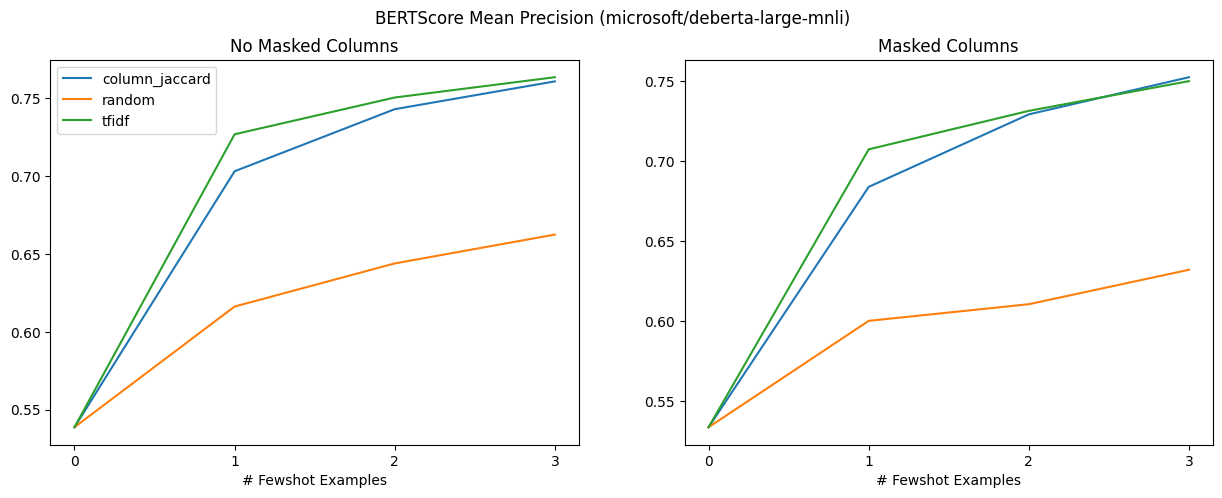

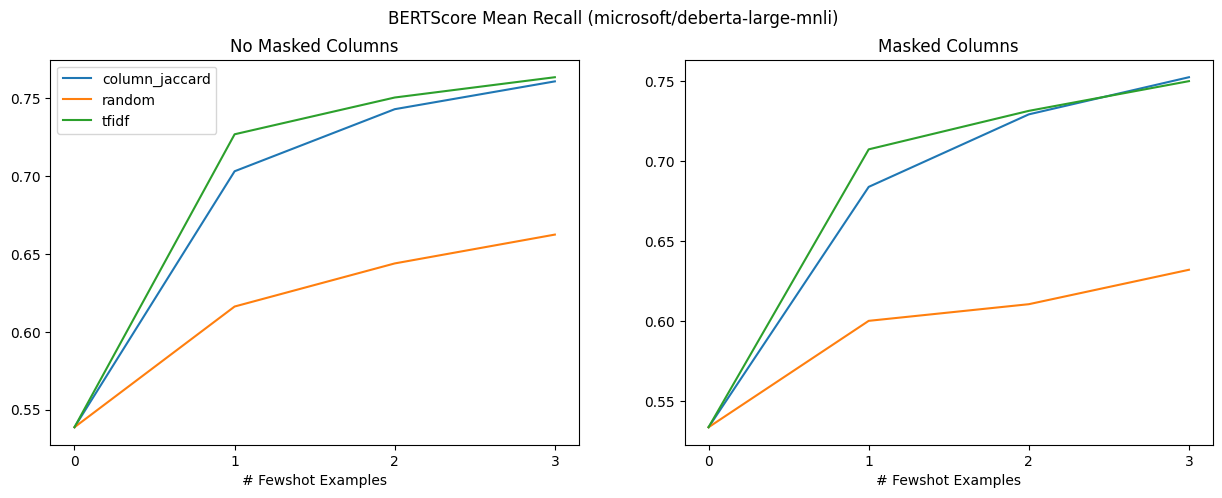

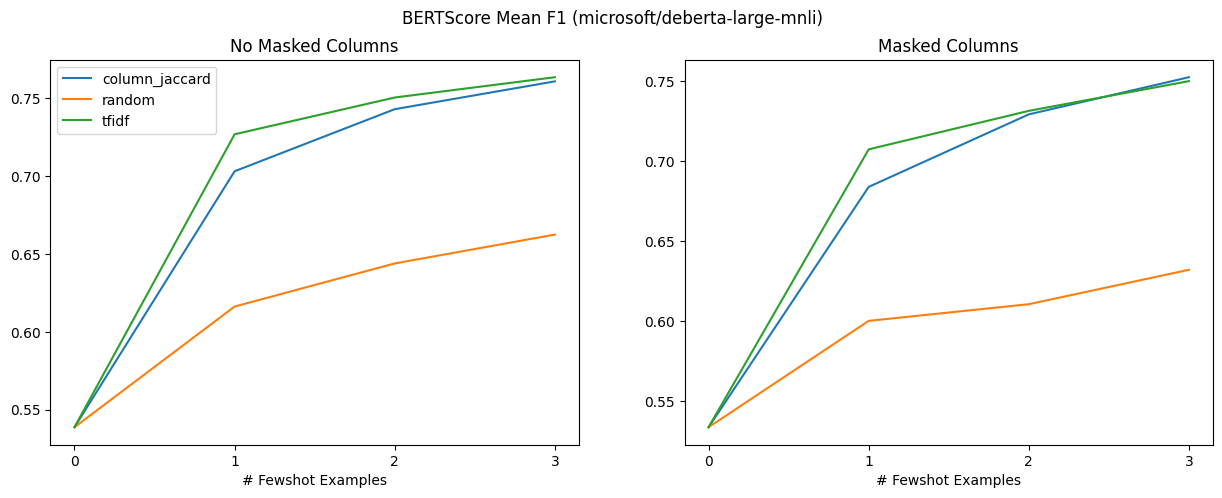

In [135]:
def graph_avg_metric(metric: str):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].title.set_text('No Masked Columns')
    ax[1].title.set_text('Masked Columns')

    for retrieval_method in results['retrieval_method'].unique():
        dff = results[results['retrieval_method'] == retrieval_method]
        with_mask = dff[dff['masked'] == True]
        no_mask = dff[dff['masked'] == False]
        
        ax[0].plot(no_mask['nshot'], no_mask['recall'], label=retrieval_method)
        ax[1].plot(with_mask['nshot'], with_mask['recall'], label=retrieval_method)
        
        for i in range(len(ax)):
            ax[i].set_xticks(list(range(4)))

        ax[0].legend()

        for i in range(2):
            ax[i].set_xlabel('# Fewshot Examples')

    fig.suptitle(f'BERTScore Mean {metric.capitalize()} (microsoft/deberta-large-mnli)')
    plt.savefig(f'images/bertscore-mean-{metric}.png')
    plt.show()

for metric in ['precision', 'recall', 'f1']: 
    graph_avg_metric(metric)

In [136]:
with_mask = results[results['masked'] == True]
no_mask = results[results['masked'] == False]

diffs = with_mask[['retrieval_method', 'nshot']]

for metric in ['precision', 'recall', 'f1']:
    diffs[f'{metric}_diff'] = no_mask[metric].to_numpy() - with_mask[metric].to_numpy()

diffs

/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_82851/1502041861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffs[f'{metric}_diff'] = no_mask[metric].to_numpy() - with_mask[metric].to_numpy()
/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_82851/1502041861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffs[f'{metric}_diff'] = no_mask[metric].to_numpy() - with_mask[metric].to_numpy()
/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_82851/1502041861.py:7: Settin

,retrieval_method,nshot,precision_diff,recall_diff,f1_diff
1,column_jaccard,0,0.030215,0.005305,0.018551
3,column_jaccard,1,0.016139,0.019522,0.017895
5,column_jaccard,2,0.010009,0.014075,0.012185
7,column_jaccard,3,0.005594,0.008731,0.007187
9,random,0,0.030215,0.005305,0.018551
11,random,1,0.019392,0.016356,0.018100
13,random,2,0.025235,0.033642,0.029937
15,random,3,0.027938,0.030648,0.029528
17,tfidf,0,0.030215,0.005305,0.018551
19,tfidf,1,0.014143,0.019827,0.017296


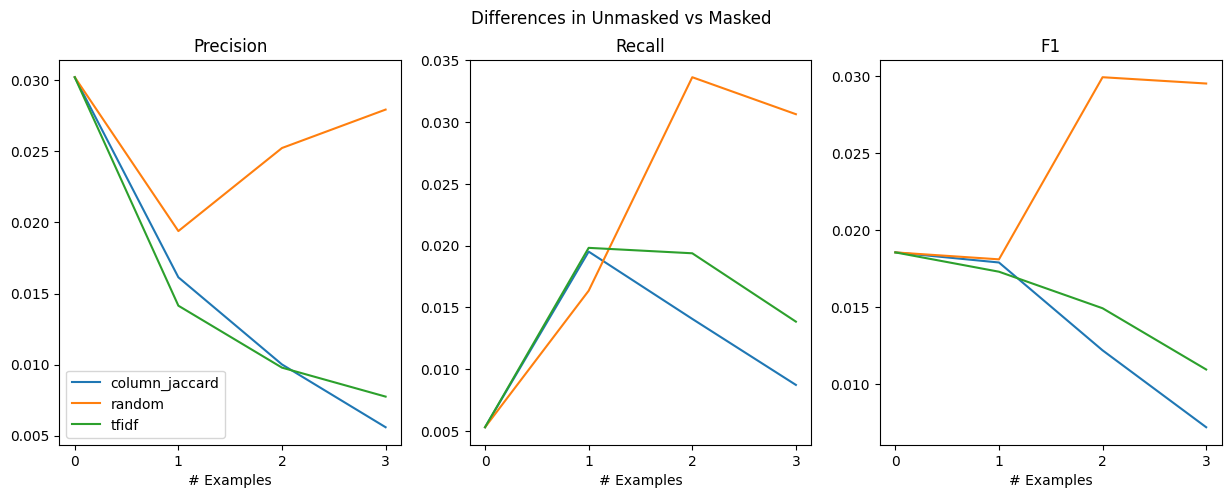

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Differences in Unmasked vs Masked')

to_plot = ['precision_diff', 'recall_diff', 'f1_diff']
for retrieval_method, dff in diffs.groupby('retrieval_method'):
    for i, metric in enumerate(to_plot):
        ax[i].plot(dff['nshot'], dff[metric], label=retrieval_method)
        
for i, retrieval_method in enumerate(to_plot):
    if i == 0:
        ax[i].legend()
    ax[i].set_xticks(list(range(4)))
    ax[i].set_xlabel('# Examples')
    ax[i].set_title(retrieval_method.split('_')[0].capitalize())

fig.savefig('images/differential.png')
plt.show()